In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.data import get_sphere
from dipy.sims.voxel import multi_tensor, multi_tensor_odf, single_tensor
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class MatrixFactorizationNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MatrixFactorizationNet, self).__init__()
        # Define the network layers
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.softplus(self.fc4(x))  # Softplus activation for the output layer
        return x
    
def apply_sparsity(F, sparsity_threshold=0.9):
    """
    Apply sparsity constraint to the output matrix F by zeroing out
    a certain percentage of the smallest absolute values.
    """
    k = int(sparsity_threshold * F.numel())
    if k > 0:
        # Zero out the k smallest absolute values in F
        _, indices = torch.topk(torch.abs(F).view(-1), k, largest=False)
        F.view(-1)[indices] = 0
    return F


from torch.utils.data import Dataset, DataLoader

class MatrixDataset(Dataset):
    def __init__(self, S, F):
        self.S = S
        self.F = F

    def __len__(self):
        return len(self.S)

    def __getitem__(self, idx):
        return self.S[idx], self.F[idx]

In [3]:
S = np.load("S.npy")
H = np.load("H.npy")
F = np.load("F.npy")
print(np.shape(S))
print(np.shape(F))
print(np.shape(H))

# Convert them to PyTorch tensors
S = torch.from_numpy(S).float()
H = torch.from_numpy(H).float()

(100000, 130)
(100000, 300)
(300, 130)


In [6]:
# Separate into training and testing set
split = 0.8
num_entries = len(S)
train_len = int(num_entries * split)

S_train = S[:train_len]
F_train = F[:train_len]

S_test = S[train_len:]
F_test = F[train_len:]
batch_size = 32 

train_dataset = MatrixDataset(S_train, F_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MatrixDataset(S_test, F_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

N_test, _ = np.shape(S_test)
N, n_b = np.shape(S_train)  
_, n = np.shape(F_train)

input_size = n_b
output_size = n

net = MatrixFactorizationNet(input_size, [512, 256, 128], output_size)
net.load_state_dict(torch.load("model_26_11.pt", map_location = torch.device('cpu')))

<All keys matched successfully>

In [12]:
F_pred_26_11 = torch.load("F_pred_26_11.pkl")
F_test_26_11 = torch.load("F_test_26_11.pkl")
H_26_11 = pd.read_pickle("H_26_11.pkl")
S_test_26_11 = pd.read_pickle("S_test_26_11.pkl")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [22]:
angle_pairs = []
thetas = []
phis = []
for theta in np.linspace(0, 170, 18):
    for phi in np.linspace(0, 350, 36):
        thetas.append(theta)
        phis.append(phi)
        angle_pair = (theta, phi)
        angle_pairs.append(angle_pair)

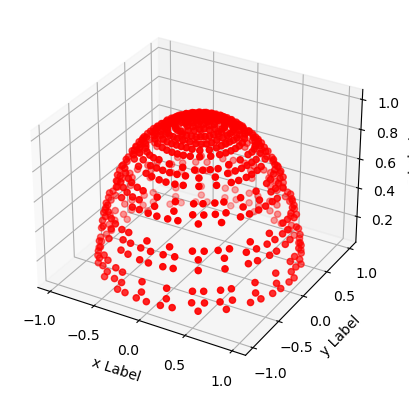

In [28]:
hemisphere = HemiSphere(theta=thetas, phi=phis)
hemisphere, _ = disperse_charges(hemisphere, 100)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(hemisphere.vertices[:,0], hemisphere.vertices[:,1], hemisphere.vertices[:,2], c='r', marker='o')

# Set labels for each axis
ax.set_xlabel('x Label')
ax.set_ylabel('y Label')
ax.set_zlabel('z Label')

# Show the plot
plt.show()

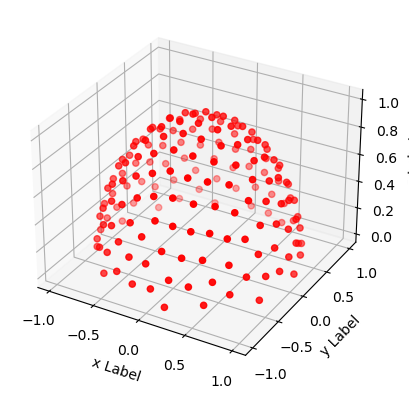

In [45]:
n = 180
angle_pairs = []
thetas = []
phis = []
np.random.seed(2)
for i in range(n):
    thetas.append(np.random.uniform(0,90))
    phis.append(np.random.uniform(0,360))

hemisphere = HemiSphere(theta=thetas, phi=phis)
hemisphere, _ = disperse_charges(hemisphere,50000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(hemisphere.vertices[:,0], hemisphere.vertices[:,1], hemisphere.vertices[:,2], c='r', marker='o')

# Set labels for each axis
ax.set_xlabel('x Label')
ax.set_ylabel('y Label')
ax.set_zlabel('z Label')

# Show the plot
plt.show()

In [56]:
angle_pairs = []
for i in range(len(hemisphere.phi)):
    angle_pairs.append((hemisphere.theta[i] * (180/np.pi), hemisphere.phi[i] * (180/np.pi)))

In [59]:
angle_pairs

[(83.80324252454373, 161.34487910539025),
 (74.83734487784767, 156.37208770224873),
 (21.763926254953265, -26.92859500361248),
 (52.76840354812005, -8.6669692365372),
 (79.58582585337993, -65.91302275539768),
 (58.9882198583094, -53.62856576328086),
 (52.320688426013255, -35.6262605893558),
 (63.09078046146131, -6.023996726586385),
 (83.13429903668352, 119.90950751539599),
 (50.85888456158604, -157.8817175937825),
 (87.28257555416006, 88.19917243697576),
 (62.52976136253346, -170.2458298013275),
 (73.61335351875249, -103.18191745241035),
 (89.3869269267914, 42.38851800916614),
 (57.90096655006516, 5.494996873847295),
 (72.64914799124669, -165.03448994514957),
 (70.36544362006391, -113.55486996336818),
 (88.31307672738686, 64.44213784020027),
 (63.981626295400616, -96.45385961818252),
 (66.94421541282078, -124.01831217194513),
 (68.27480625948088, 62.800762316309495),
 (83.95920513860332, -163.84696537951365),
 (63.01035501559433, 164.384955479019),
 (89.40945348410918, 170.251007791396